In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
import warnings
# Ignoring future warnings and deprecation warnings so as not to make the notebook full of warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/Admin/OneDrive/Desktop/Personal Items/NorthWind Project/Fact-order.csv')
df.tail()

,orderID,productID,customerID,employeeID,supplierID,orderdatekey,unitPrice,quantity,discount
495,10789,18,FOLIG,1,7,19971222,62.5,30,0.00
496,10789,63,FOLIG,1,7,19971222,43.9,30,0.00
497,10264,2,FOLKO,6,1,19960724,15.2,35,0.00
498,10264,41,FOLKO,6,19,19960724,7.7,25,0.15
499,10327,2,FOLKO,2,1,19961011,15.2,25,0.20


In [3]:
df['Amount'] = df['quantity']*df['unitPrice']
monetary = df.groupby('customerID')['Amount'].sum()
monetary = monetary.reset_index()
monetary.tail()

,customerID,Amount
18,EASTC,15033.66
19,ERNSH,113236.68
20,FAMIA,4438.90
21,FOLIG,11666.90
22,FOLKO,1104.50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   orderID       500 non-null    int64  
 1   productID     500 non-null    int64  
 2   customerID    500 non-null    object 
 3   employeeID    500 non-null    int64  
 4   supplierID    500 non-null    int64  
 5   orderdatekey  500 non-null    int64  
 6   unitPrice     500 non-null    float64
 7   quantity      500 non-null    int64  
 8   discount      500 non-null    float64
 9   Amount        500 non-null    float64
dtypes: float64(3), int64(6), object(1)
memory usage: 39.2+ KB


In [5]:
df.describe()

,orderID,productID,employeeID,supplierID,orderdatekey,unitPrice,quantity,discount,Amount
count,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000
mean,10657.206000,39.820000,4.540000,14.354000,1.997188e+07,24.737660,24.862000,0.047300,611.309600
std,241.686906,21.936591,2.531643,8.248683,6.762259e+03,23.929216,20.529537,0.080066,782.635886
min,10254.000000,1.000000,1.000000,1.000000,1.996071e+07,2.000000,1.000000,0.000000,4.800000
25%,10436.000000,21.000000,3.000000,7.000000,1.997020e+07,11.200000,10.000000,0.000000,150.000000
50%,10646.500000,41.000000,4.000000,14.000000,1.997083e+07,18.400000,20.000000,0.000000,378.000000
75%,10866.000000,59.000000,7.000000,21.000000,1.998020e+07,32.000000,30.000000,0.050000,723.750000
max,11076.000000,77.000000,9.000000,29.000000,1.998051e+07,263.500000,130.000000,0.250000,6360.000000


**RFM and K-Means**

In [6]:
frequency = df.groupby('customerID')['orderID'].count()
frequency = frequency.reset_index()
frequency.head()

,customerID,orderID
0,ALFKI,12
1,ANATR,10
2,ANTON,17
3,AROUT,30
4,BERGS,52


In [7]:
df['orderdatekey'] = pd.to_datetime(df['orderdatekey'], format='%Y%m%d')
df['Diff'] = max(df['orderdatekey']) - df['orderdatekey']
recency = df.groupby('customerID')['Diff'].min()
recency = recency.reset_index()
recency['Diff'] = recency['Diff'].dt.components.days
recency.head()

,customerID,Diff
0,ALFKI,27
1,ANATR,63
2,ANTON,98
3,AROUT,26
4,BERGS,63


In [8]:
rfm = pd.merge(recency, frequency, on = 'customerID', how = 'inner')

In [9]:
rfm = pd.merge(rfm, monetary, on = 'customerID', how = 'inner')

In [10]:
rfm.columns = ['customerID', 'Recency', 'Frequency', 'Monetary']

In [11]:
rfm_clusters = rfm
rfm = rfm.drop('customerID', axis=1)

In [12]:
rfm

,Recency,Frequency,Monetary
0,27,12,4596.20
1,63,10,1402.95
2,98,17,7515.35
3,26,30,13806.50
4,63,52,26968.15
5,7,14,3239.80
6,114,26,19088.00
7,43,6,5297.80
8,0,44,23850.95
9,12,35,22607.70


**KMeans Clustering**

***a. Elbove curve***

In [13]:
import plotly.graph_objects as go

inertia_values = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=50)
    kmeans.fit(rfm)
    inertia_values.append(kmeans.inertia_)

# Create the elbow plot
fig = go.Figure(data=go.Scatter(x=list(range(2, 8)), y=inertia_values, mode='lines+markers'))
fig.update_layout(
    title='Elbow Method',
    xaxis_title='Number of clusters',
    yaxis_title='Inertia',
    height=600)  
fig.show()

***b. KMeans clustering***

In [17]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=50)
rfm['Cluster'] = kmeans.fit_predict(rfm)
rfm

,Recency,Frequency,Monetary,Cluster
0,27,12,4596.20,0
1,63,10,1402.95,0
2,98,17,7515.35,0
3,26,30,13806.50,2
4,63,52,26968.15,2
5,7,14,3239.80,0
6,114,26,19088.00,2
7,43,6,5297.80,0
8,0,44,23850.95,2
9,12,35,22607.70,2


In [15]:
# Extract the centroids for each cluster
centroids = kmeans.cluster_centers_

# Display the centroids
centroids_df = pd.DataFrame(centroids, columns=['Recency', 'Frequency', 'Monetary'])
centroids_df

,Recency,Frequency,Monetary
0,134.428571,10.857143,3322.14
1,1.000000,102.000000,113236.68
2,46.500000,30.750000,18238.52


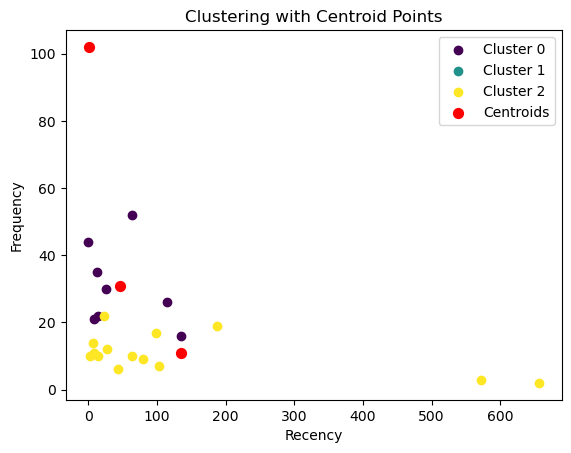

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Assuming you have already fitted the K-means model and obtained the centroids
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm)
centroids = kmeans.cluster_centers_

# Get unique cluster labels
unique_labels = np.unique(kmeans.labels_)

# Create a colormap with a color for each cluster
colormap = plt.cm.get_cmap('viridis', len(unique_labels))

# Plotting the data points with different colors for each cluster
for label in unique_labels:
    cluster_indices = kmeans.labels_ == label
    plt.scatter(rfm['Recency'][cluster_indices], rfm['Frequency'][cluster_indices], c=[colormap(label)], label=f'Cluster {label}')

# Plotting the centroid points in red
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=50, c='red', label='Centroids')

# Customize the plot as needed
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Clustering with Centroid Points')
plt.legend()

# Show the plot
plt.show()